
=== Basic Data Quality Check ===

=== CSV Report ===
check_type,table,column,issue,severity
Missing Values,customers,email,2 missing values (18.18%),High
Missing Values,orders,customer_id,1 missing values (9.09%),Medium
Invalid Values,customers,age,1 invalid values (9.09%) - Rule: age > 0 AND age < 120,High
Invalid Values,orders,amount,1 invalid values (9.09%) - Rule: amount > 0,High
Consistency,orders,customer_id,1 orphaned records with no matching customers record,Medium
Freshness,orders,order_date,Data is stale. Last update was 16645.4 hours ago (max: 8760),Medium
Outliers,orders,amount,"1 outliers (9.09%) outside range [-43.03, 310.03]",Medium


=== JSON Report (Summary) ===
{
  "start_time": "2025-05-13T13:22:25.169492",
  "end_time": "2025-05-13T13:22:25.201106",
  "execution_time_seconds": 0.031614,
  "total_issues": 7,
  "issues_by_severity": {
    "High": 3,
    "Medium": 4,
    "Low": 0
  },
  "issues_by_type": {
    "Missing Values": 2,
    "Invalid Values": 2,
    "Consist

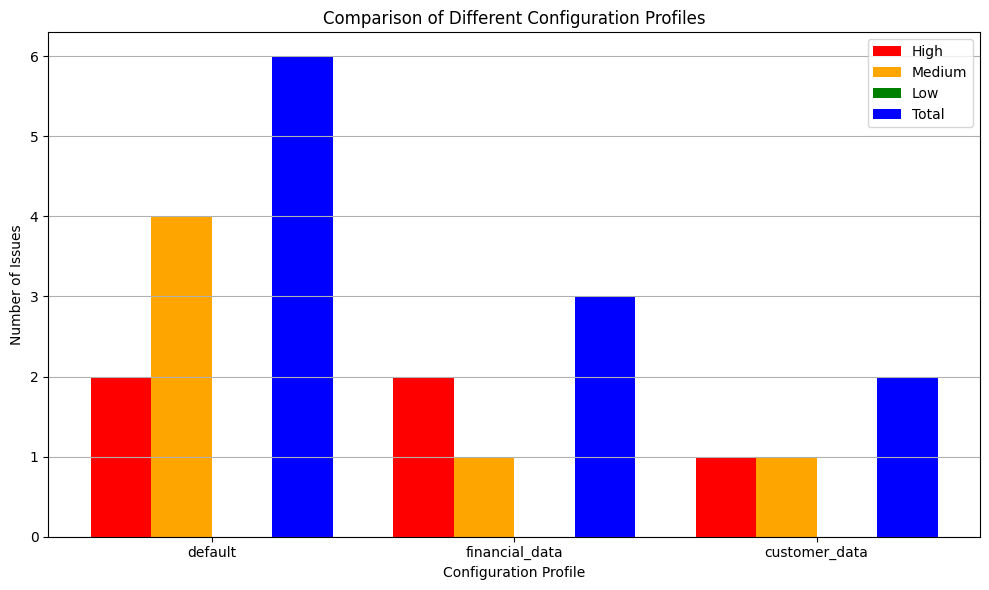


Key differences between profiles:
- Default: Balanced configuration for general purpose
- Financial Data: Stricter freshness requirements (24h vs 1 year), wider range for outliers
- Customer Data: Enforces email format validation, adults only (age >= 18)

=== Simulating Scheduled Runs ===

Running check for 2025-05-13
Found 6 issues: 2 High, 4 Medium, 0 Low

Running check for 2025-05-14
Found 6 issues: 2 High, 4 Medium, 0 Low

Running check for 2025-05-15
Found 6 issues: 2 High, 4 Medium, 0 Low
⚠️ Injecting problematic data on day 3...

Running check for 2025-05-16
Found 7 issues: 2 High, 5 Medium, 0 Low

Running check for 2025-05-17
Found 6 issues: 2 High, 4 Medium, 0 Low
🔧 Fixing some issues on day 5...

Running check for 2025-05-18
Found 4 issues: 0 High, 4 Medium, 0 Low

Running check for 2025-05-19
Found 4 issues: 0 High, 4 Medium, 0 Low


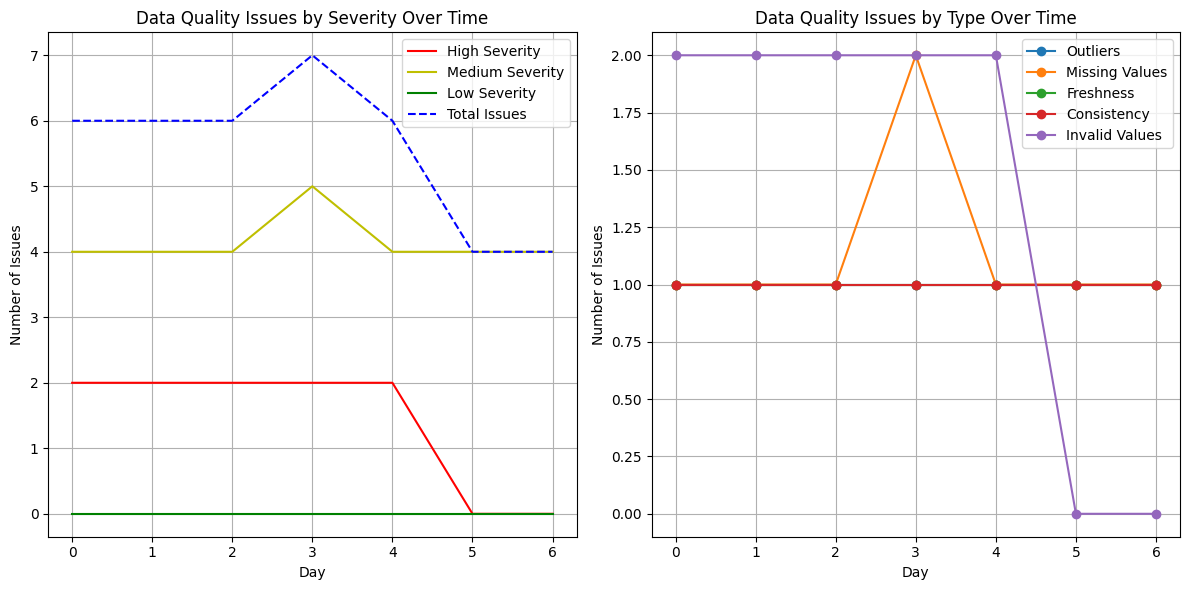


=== ETL Pipeline Simulation ===

Step 1: Extracting data...
Simulating extraction of new order data...

Step 2: Running pre-transformation quality checks...

Step 3: Transforming data...
Applying business transformations...

Step 4: Running post-transformation quality checks...

Step 5: Loading data to destination...
Simulating data load to data warehouse...
✅ ETL pipeline completed successfully!


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os
import datetime
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.application import MIMEApplication
import json
import logging
from io import StringIO
import time

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger('DataQualityChecker')

class SQLDataQualityChecker:
    def __init__(self, db_connection, config=None):
        """
        Initialize the Data Quality Checker

        Args:
            db_connection: SQLite connection object
            config: Dictionary containing configuration for checks
        """
        self.conn = db_connection
        self.config = config or {}
        self.issues = []
        self.report_data = {}
        self.start_time = datetime.datetime.now()

    def run_query(self, query, params=None):
        """Execute SQL query and return results"""
        try:
            if params:
                return pd.read_sql_query(query, self.conn, params=params)
            else:
                return pd.read_sql_query(query, self.conn)
        except Exception as e:
            logger.error(f"Query execution error: {e}")
            logger.error(f"Query: {query}")
            return pd.DataFrame()

    def get_tables(self):
        """Get list of all tables in the database"""
        query = "SELECT name FROM sqlite_master WHERE type='table'"
        tables = self.run_query(query)
        return tables['name'].tolist()

    def get_columns(self, table):
        """Get column information for a table"""
        query = f"PRAGMA table_info({table})"
        return self.run_query(query)

    def check_missing_values(self, tables=None):
        """
        Check for missing values in all tables or specified tables

        Args:
            tables: List of tables to check, if None checks all tables
        """
        logger.info("Checking for missing values...")

        if tables is None:
            tables = self.get_tables()

        missing_data = {}

        for table in tables:
            columns = self.get_columns(table)
            for _, column in columns.iterrows():
                col_name = column['name']
                query = f"""
                SELECT COUNT(*) as total_rows,
                       SUM(CASE WHEN {col_name} IS NULL THEN 1 ELSE 0 END) as null_count
                FROM {table}
                """
                result = self.run_query(query)

                if not result.empty:
                    total = result['total_rows'].iloc[0]
                    nulls = result['null_count'].iloc[0]

                    if nulls > 0:
                        pct_missing = (nulls / total) * 100 if total > 0 else 0
                        self.issues.append({
                            'check_type': 'Missing Values',
                            'table': table,
                            'column': col_name,
                            'issue': f"{nulls} missing values ({pct_missing:.2f}%)",
                            'severity': 'High' if pct_missing > 10 else 'Medium' if pct_missing > 1 else 'Low'
                        })

                        if table not in missing_data:
                            missing_data[table] = {}
                        missing_data[table][col_name] = {
                            'total': int(total),
                            'nulls': int(nulls),
                            'pct_missing': float(pct_missing)
                        }

        self.report_data['missing_values'] = missing_data
        return missing_data

    def check_duplicates(self, tables=None, key_columns=None):
        """
        Check for duplicate rows in tables

        Args:
            tables: List of tables to check
            key_columns: Dict mapping table names to lists of columns that should be unique
        """
        logger.info("Checking for duplicates...")

        if tables is None:
            tables = self.get_tables()

        if key_columns is None:
            key_columns = {}

        duplicate_data = {}

        for table in tables:
            # If key columns not specified, use all columns
            columns = key_columns.get(table, None)

            if columns is None:
                columns_df = self.get_columns(table)
                columns = columns_df['name'].tolist()

            # Skip if no columns to check
            if not columns:
                continue

            columns_str = ', '.join(columns)
            query = f"""
            SELECT {columns_str}, COUNT(*) as count
            FROM {table}
            GROUP BY {columns_str}
            HAVING COUNT(*) > 1
            """

            duplicates = self.run_query(query)

            if not duplicates.empty:
                dup_count = len(duplicates)
                total_dups = duplicates['count'].sum() - dup_count

                self.issues.append({
                    'check_type': 'Duplicates',
                    'table': table,
                    'column': ', '.join(columns),
                    'issue': f"Found {dup_count} sets of duplicates with {total_dups} duplicate rows",
                    'severity': 'High' if total_dups > 10 else 'Medium' if total_dups > 1 else 'Low'
                })

                duplicate_data[table] = {
                    'duplicate_sets': int(dup_count),
                    'total_duplicates': int(total_dups),
                    'sample': duplicates.head(5).to_dict('records')
                }

        self.report_data['duplicates'] = duplicate_data
        return duplicate_data

    def check_invalid_values(self, rules=None):
        """
        Check for invalid values based on business rules

        Args:
            rules: Dict mapping tables to column rules
                  Format: {'table': {'column': 'SQL condition for valid values'}}
        """
        logger.info("Checking for invalid values...")

        if rules is None:
            rules = self.config.get('business_rules', {})

        invalid_data = {}

        for table, columns in rules.items():
            table_invalid = {}

            for column, rule in columns.items():
                query = f"""
                SELECT COUNT(*) as invalid_count
                FROM {table}
                WHERE NOT({rule})
                """

                result = self.run_query(query)

                if not result.empty:
                    invalid_count = result['invalid_count'].iloc[0]

                    if invalid_count > 0:
                        # Get total count for percentage
                        total_query = f"SELECT COUNT(*) as total FROM {table}"
                        total_result = self.run_query(total_query)
                        total = total_result['total'].iloc[0]
                        pct_invalid = (invalid_count / total) * 100 if total > 0 else 0

                        self.issues.append({
                            'check_type': 'Invalid Values',
                            'table': table,
                            'column': column,
                            'issue': f"{invalid_count} invalid values ({pct_invalid:.2f}%) - Rule: {rule}",
                            'severity': 'High' if pct_invalid > 5 else 'Medium' if pct_invalid > 1 else 'Low'
                        })

                        # Get sample of invalid records
                        sample_query = f"""
                        SELECT * FROM {table}
                        WHERE NOT({rule})
                        LIMIT 5
                        """
                        sample = self.run_query(sample_query)

                        table_invalid[column] = {
                            'rule': rule,
                            'invalid_count': int(invalid_count),
                            'pct_invalid': float(pct_invalid),
                            'sample': sample.to_dict('records')
                        }

            if table_invalid:
                invalid_data[table] = table_invalid

        self.report_data['invalid_values'] = invalid_data
        return invalid_data

    def check_consistency(self, relationships=None):
        """
        Check referential integrity between tables

        Args:
            relationships: List of dicts with foreign key relationships
                Format: [{'source_table': 'orders',
                          'source_column': 'customer_id',
                          'target_table': 'customers',
                          'target_column': 'id'}]
        """
        logger.info("Checking data consistency...")

        if relationships is None:
            relationships = self.config.get('relationships', [])

        consistency_data = {}

        for rel in relationships:
            source_table = rel['source_table']
            source_column = rel['source_column']
            target_table = rel['target_table']
            target_column = rel['target_column']

            query = f"""
            SELECT COUNT(*) as orphaned_count
            FROM {source_table} s
            LEFT JOIN {target_table} t ON s.{source_column} = t.{target_column}
            WHERE t.{target_column} IS NULL
            AND s.{source_column} IS NOT NULL
            """

            result = self.run_query(query)

            if not result.empty:
                orphaned = result['orphaned_count'].iloc[0]

                if orphaned > 0:
                    # Get sample of orphaned records
                    sample_query = f"""
                    SELECT s.*
                    FROM {source_table} s
                    LEFT JOIN {target_table} t ON s.{source_column} = t.{target_column}
                    WHERE t.{target_column} IS NULL
                    AND s.{source_column} IS NOT NULL
                    LIMIT 5
                    """
                    sample = self.run_query(sample_query)

                    rel_key = f"{source_table}.{source_column} -> {target_table}.{target_column}"
                    self.issues.append({
                        'check_type': 'Consistency',
                        'table': source_table,
                        'column': source_column,
                        'issue': f"{orphaned} orphaned records with no matching {target_table} record",
                        'severity': 'High' if orphaned > 10 else 'Medium' if orphaned > 0 else 'Low'
                    })

                    consistency_data[rel_key] = {
                        'orphaned_count': int(orphaned),
                        'sample': sample.to_dict('records')
                    }

        self.report_data['consistency'] = consistency_data
        return consistency_data

    def check_schema(self, expected_schema=None):
        """
        Validate schema against expected schema

        Args:
            expected_schema: Dict mapping tables to expected columns and types
                Format: {'table': {'column': 'type'}}
        """
        logger.info("Checking schema...")

        if expected_schema is None:
            expected_schema = self.config.get('schema', {})

        schema_issues = {}

        for table, expected_columns in expected_schema.items():
            table_issues = []

            # Get actual schema
            columns_df = self.get_columns(table)

            if columns_df.empty:
                self.issues.append({
                    'check_type': 'Schema',
                    'table': table,
                    'column': 'N/A',
                    'issue': f"Table {table} does not exist",
                    'severity': 'High'
                })
                schema_issues[table] = {'table_missing': True}
                continue

            actual_columns = {row['name']: row['type'] for _, row in columns_df.iterrows()}

            # Check for missing columns
            for col_name, col_type in expected_columns.items():
                if col_name not in actual_columns:
                    self.issues.append({
                        'check_type': 'Schema',
                        'table': table,
                        'column': col_name,
                        'issue': f"Column {col_name} is missing",
                        'severity': 'High'
                    })
                    table_issues.append({
                        'column': col_name,
                        'issue': 'missing',
                        'expected_type': col_type
                    })
                elif actual_columns[col_name].lower() != col_type.lower():
                    self.issues.append({
                        'check_type': 'Schema',
                        'table': table,
                        'column': col_name,
                        'issue': f"Column {col_name} has type {actual_columns[col_name]} but expected {col_type}",
                        'severity': 'Medium'
                    })
                    table_issues.append({
                        'column': col_name,
                        'issue': 'type_mismatch',
                        'expected_type': col_type,
                        'actual_type': actual_columns[col_name]
                    })

            if table_issues:
                schema_issues[table] = {'issues': table_issues}

        self.report_data['schema'] = schema_issues
        return schema_issues

    def check_freshness(self, freshness_rules=None):
        """
        Check data freshness based on timestamp columns

        Args:
            freshness_rules: List of dicts with freshness rules
                Format: [{'table': 'orders',
                          'timestamp_column': 'created_at',
                          'max_age_hours': 24}]
        """
        logger.info("Checking data freshness...")

        if freshness_rules is None:
            freshness_rules = self.config.get('freshness', [])

        freshness_data = {}

        for rule in freshness_rules:
            table = rule['table']
            timestamp_column = rule['timestamp_column']
            max_age_hours = rule.get('max_age_hours', 24)

            # SQLite doesn't have native datetime functions like PostgreSQL
            # So we'll use julianday for date calculations
            query = f"""
            SELECT
                MAX({timestamp_column}) as latest_timestamp,
                (julianday('now') - julianday(MAX({timestamp_column}))) * 24 as hours_since_update
            FROM {table}
            """

            result = self.run_query(query)

            if not result.empty and not pd.isna(result['latest_timestamp'].iloc[0]):
                latest = result['latest_timestamp'].iloc[0]
                hours_since = result['hours_since_update'].iloc[0]

                freshness_data[table] = {
                    'latest_timestamp': latest,
                    'hours_since_update': float(hours_since),
                    'max_age_hours': max_age_hours,
                    'is_stale': hours_since > max_age_hours
                }

                if hours_since > max_age_hours:
                    self.issues.append({
                        'check_type': 'Freshness',
                        'table': table,
                        'column': timestamp_column,
                        'issue': f"Data is stale. Last update was {hours_since:.1f} hours ago (max: {max_age_hours})",
                        'severity': 'High' if hours_since > max_age_hours * 2 else 'Medium'
                    })

        self.report_data['freshness'] = freshness_data
        return freshness_data

    def detect_outliers(self, outlier_rules=None):
        """
        Detect outliers in numerical columns

        Args:
            outlier_rules: List of dicts with outlier detection rules
                Format: [{'table': 'orders',
                          'column': 'amount',
                          'method': 'zscore',
                          'threshold': 3}]
        """
        logger.info("Detecting outliers...")

        if outlier_rules is None:
            outlier_rules = self.config.get('outliers', [])

        outlier_data = {}

        for rule in outlier_rules:
            table = rule['table']
            column = rule['column']
            method = rule.get('method', 'zscore')
            threshold = rule.get('threshold', 3)

            # Get basic stats
            query = f"""
            SELECT
                AVG({column}) as mean,
                (SUM({column} * {column}) / COUNT({column}) - (AVG({column}) * AVG({column}))) as variance
            FROM {table}
            WHERE {column} IS NOT NULL
            """

            stats = self.run_query(query)

            if not stats.empty and not pd.isna(stats['mean'].iloc[0]):
                mean = stats['mean'].iloc[0]
                std_dev = np.sqrt(stats['variance'].iloc[0])

                if method == 'zscore':
                    lower_bound = mean - threshold * std_dev
                    upper_bound = mean + threshold * std_dev

                    outlier_query = f"""
                    SELECT COUNT(*) as outlier_count
                    FROM {table}
                    WHERE {column} < {lower_bound} OR {column} > {upper_bound}
                    """

                    outlier_result = self.run_query(outlier_query)
                    outlier_count = outlier_result['outlier_count'].iloc[0]

                    if outlier_count > 0:
                        # Get sample of outliers
                        sample_query = f"""
                        SELECT *
                        FROM {table}
                        WHERE {column} < {lower_bound} OR {column} > {upper_bound}
                        LIMIT 5
                        """
                        sample = self.run_query(sample_query)

                        # Get total count for percentage
                        total_query = f"SELECT COUNT(*) as total FROM {table} WHERE {column} IS NOT NULL"
                        total_result = self.run_query(total_query)
                        total = total_result['total'].iloc[0]
                        pct_outliers = (outlier_count / total) * 100 if total > 0 else 0

                        self.issues.append({
                            'check_type': 'Outliers',
                            'table': table,
                            'column': column,
                            'issue': f"{outlier_count} outliers ({pct_outliers:.2f}%) outside range [{lower_bound:.2f}, {upper_bound:.2f}]",
                            'severity': 'Medium' if pct_outliers > 1 else 'Low'
                        })

                        if table not in outlier_data:
                            outlier_data[table] = {}

                        outlier_data[table][column] = {
                            'mean': float(mean),
                            'std_dev': float(std_dev),
                            'lower_bound': float(lower_bound),
                            'upper_bound': float(upper_bound),
                            'outlier_count': int(outlier_count),
                            'pct_outliers': float(pct_outliers),
                            'sample': sample.to_dict('records')
                        }

        self.report_data['outliers'] = outlier_data
        return outlier_data

    def auto_fix_issues(self, fixes=None):
        """
        Automatically fix simple issues

        Args:
            fixes: Dict with fix configurations
        """
        logger.info("Auto-fixing issues...")

        if fixes is None:
            fixes = self.config.get('auto_fixes', {})

        fix_results = {}

        # Fix duplicates
        if fixes.get('remove_duplicates', False):
            tables = fixes.get('duplicate_tables', self.get_tables())
            key_columns = fixes.get('duplicate_key_columns', {})

            for table in tables:
                columns = key_columns.get(table, None)

                if columns is None:
                    columns_df = self.get_columns(table)
                    columns = columns_df['name'].tolist()

                if not columns:
                    continue

                columns_str = ', '.join(columns)

                # Create temporary table with unique rows
                temp_table = f"temp_{table}_unique"
                create_temp = f"""
                CREATE TEMPORARY TABLE {temp_table} AS
                SELECT * FROM {table}
                GROUP BY {columns_str}
                """

                try:
                    self.conn.execute(create_temp)

                    # Delete all rows from original table
                    self.conn.execute(f"DELETE FROM {table}")

                    # Insert unique rows back
                    self.conn.execute(f"INSERT INTO {table} SELECT * FROM {temp_table}")

                    # Drop temp table
                    self.conn.execute(f"DROP TABLE {temp_table}")

                    # Commit changes
                    self.conn.commit()

                    fix_results[f"duplicates_{table}"] = "Fixed"
                except Exception as e:
                    logger.error(f"Error fixing duplicates in {table}: {e}")
                    fix_results[f"duplicates_{table}"] = f"Error: {str(e)}"

        # Fill missing values
        if fixes.get('fill_missing', False):
            fill_rules = fixes.get('fill_rules', {})

            for table, columns in fill_rules.items():
                for column, value in columns.items():
                    try:
                        update_query = f"""
                        UPDATE {table}
                        SET {column} = ?
                        WHERE {column} IS NULL
                        """

                        self.conn.execute(update_query, (value,))
                        self.conn.commit()

                        fix_results[f"missing_{table}_{column}"] = f"Filled with '{value}'"
                    except Exception as e:
                        logger.error(f"Error filling missing values in {table}.{column}: {e}")
                        fix_results[f"missing_{table}_{column}"] = f"Error: {str(e)}"

        self.report_data['auto_fixes'] = fix_results
        return fix_results

    def run_all_checks(self):
        """Run all data quality checks"""
        logger.info("Running all data quality checks...")

        # Core checks
        self.check_missing_values()
        self.check_duplicates()
        self.check_invalid_values()
        self.check_consistency()
        self.check_schema()
        self.check_freshness()
        self.detect_outliers()

        # Auto-fix if configured
        if self.config.get('auto_fixes', {}).get('enabled', False):
            self.auto_fix_issues()

        # Calculate execution time
        self.end_time = datetime.datetime.now()
        self.execution_time = (self.end_time - self.start_time).total_seconds()

        logger.info(f"All checks completed in {self.execution_time:.2f} seconds")
        logger.info(f"Found {len(self.issues)} issues")

        return self.issues

    def generate_report(self, format='csv', output_path=None):
        """
        Generate a report of all data quality issues

        Args:
            format: Output format ('csv', 'json', 'html')
            output_path: Path to save the report

        Returns:
            Report content
        """
        logger.info(f"Generating {format} report...")

        # Add summary information
        self.report_data['summary'] = {
            'start_time': self.start_time.isoformat(),
            'end_time': self.end_time.isoformat() if hasattr(self, 'end_time') else datetime.datetime.now().isoformat(),
            'execution_time_seconds': getattr(self, 'execution_time', 0),
            'total_issues': len(self.issues),
            'issues_by_severity': {
                'High': len([i for i in self.issues if i.get('severity') == 'High']),
                'Medium': len([i for i in self.issues if i.get('severity') == 'Medium']),
                'Low': len([i for i in self.issues if i.get('severity') == 'Low'])
            },
            'issues_by_type': {}
        }

        # Count issues by type
        for issue in self.issues:
            check_type = issue.get('check_type', 'Unknown')
            if check_type not in self.report_data['summary']['issues_by_type']:
                self.report_data['summary']['issues_by_type'][check_type] = 0
            self.report_data['summary']['issues_by_type'][check_type] += 1

        # Create issues dataframe
        issues_df = pd.DataFrame(self.issues)

        if format == 'csv':
            output = issues_df.to_csv(index=False)
            if output_path:
                issues_df.to_csv(output_path, index=False)

        elif format == 'json':
            output = json.dumps(self.report_data, indent=2, default=str)
            if output_path:
                with open(output_path, 'w') as f:
                    f.write(output)

        elif format == 'html':
            # Create a more detailed HTML report
            html_output = StringIO()

            # Write header with ESCAPED curly braces in CSS
            html_output.write("""
            <html>
            <head>
                <title>Data Quality Report</title>
                <style>
                    body {{ font-family: Arial, sans-serif; margin: 20px; }}
                    h1, h2, h3 {{ color: #333366; }}
                    table {{ border-collapse: collapse; width: 100%; margin-bottom: 20px; }}
                    th, td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
                    th {{ background-color: #f2f2f2; }}
                    tr:nth-child(even) {{ background-color: #f9f9f9; }}
                    .high {{ color: #cc0000; font-weight: bold; }}
                    .medium {{ color: #ff9900; }}
                    .low {{ color: #339900; }}
                    .summary {{ background-color: #f0f0f0; padding: 15px; border-radius: 5px; }}
                </style>
            </head>
            <body>
                <h1>Data Quality Report</h1>
                <div class="summary">
                    <h2>Summary</h2>
                    <p>Start Time: {start_time}</p>
                    <p>End Time: {end_time}</p>
                    <p>Execution Time: {execution_time:.2f} seconds</p>
                    <p>Total Issues: {total_issues}</p>
                    <p>Issues by Severity: High: {high}, Medium: {medium}, Low: {low}</p>
                </div>
            """.format(
                start_time=self.report_data['summary']['start_time'],
                end_time=self.report_data['summary']['end_time'],
                execution_time=self.report_data['summary']['execution_time_seconds'],
                total_issues=self.report_data['summary']['total_issues'],
                high=self.report_data['summary']['issues_by_severity']['High'],
                medium=self.report_data['summary']['issues_by_severity']['Medium'],
                low=self.report_data['summary']['issues_by_severity']['Low']
            ))

            # Issues table
            if not issues_df.empty:
                html_output.write("<h2>Issues Found</h2>")
                issues_html = issues_df.to_html(index=False, classes='issues-table')
                issues_html = issues_html.replace('>High<', ' class="high">High<')
                issues_html = issues_html.replace('>Medium<', ' class="medium">Medium<')
                issues_html = issues_html.replace('>Low<', ' class="low">Low<')
                html_output.write(issues_html)
            else:
                html_output.write("<h2>No Issues Found</h2>")

            # Close HTML
            html_output.write("</body></html>")

            output = html_output.getvalue()
            if output_path:
                with open(output_path, 'w') as f:
                    f.write(output)
        else:
            output = str(issues_df)

        return output

    def send_email_report(self, email_config):
        """
        Send email report

        Args:
            email_config: Dict with email configuration
        """
        if not self.issues:
            logger.info("No issues to report")
            return False

        try:
            sender = email_config.get('sender')
            recipients = email_config.get('recipients', [])
            subject = email_config.get('subject', 'Data Quality Report')
            smtp_server = email_config.get('smtp_server')
            smtp_port = email_config.get('smtp_port', 587)
            username = email_config.get('username')
            password = email_config.get('password')

            if not (sender and recipients and smtp_server and username and password):
                logger.error("Incomplete email configuration")
                return False

            # Create message
            msg = MIMEMultipart()
            msg['From'] = sender
            msg['To'] = ', '.join(recipients)
            msg['Subject'] = subject

            # Add HTML body
            html_report = self.generate_report(format='html')
            msg.attach(MIMEText(html_report, 'html'))

            # Add CSV attachment
            csv_report = self.generate_report(format='csv')
            attachment = MIMEApplication(csv_report)
            attachment['Content-Disposition'] = 'attachment; filename="data_quality_report.csv"'
            msg.attach(attachment)

            # Connect to server and send
            server = smtplib.SMTP(smtp_server, smtp_port)
            server.starttls()
            server.login(username, password)
            server.send_message(msg)
            server.quit()

            logger.info(f"Email report sent to {', '.join(recipients)}")
            return True

        except Exception as e:
            logger.error(f"Error sending email: {e}")
            return False

# Sample usage and test function
def create_sample_database():
    """Create a sample SQLite database for testing"""
    conn = sqlite3.connect(':memory:')

    # Create customers table
    conn.execute('''
    CREATE TABLE customers (
        id INTEGER PRIMARY KEY,
        name TEXT NOT NULL,
        email TEXT,
        age INTEGER,
        signup_date TEXT
    )
    ''')

    # Create orders table
    conn.execute('''
    CREATE TABLE orders (
        id INTEGER PRIMARY KEY,
        customer_id INTEGER,
        amount REAL,
        status TEXT,
        order_date TEXT
    )
    ''')

    # Create products table
    conn.execute('''
    CREATE TABLE products (
        id INTEGER PRIMARY KEY,
        name TEXT NOT NULL,
        price REAL,
        stock INTEGER
    )
    ''')

    # Insert sample data into customers
    customers = [
        (1, 'John Doe', 'john@example.com', 35, '2023-01-15'),
        (2, 'Jane Smith', 'jane@example.com', 28, '2023-02-20'),
        (3, 'Bob Johnson', None, 42, '2023-03-10'),
        (4, 'Alice Brown', 'alice@example.com', -5, '2023-04-05'),  # Invalid age
        (5, 'Charlie Davis', 'charlie@example.com', 31, '2023-05-12'),
        (6, 'Eve Wilson', 'eve@example.com', 29, '2023-06-18'),
        (7, 'Frank Miller', None, 45, '2023-07-22'),
        (8, 'Grace Taylor', 'grace@example.com', 37, '2023-08-30'),
        (9, 'Henry Clark', 'henry@example.com', 33, '2023-09-05'),
        (10, 'Ivy Martin', 'ivy@example.com', 26, '2023-10-15'),
        # Duplicate entry
        (11, 'Ivy Martin', 'ivy@example.com', 26, '2023-10-15')
    ]

    conn.executemany('INSERT INTO customers VALUES (?, ?, ?, ?, ?)', customers)

    # Insert sample data into orders
    orders = [
        (1, 1, 100.50, 'completed', '2023-05-01'),
        (2, 2, 75.25, 'completed', '2023-05-05'),
        (3, 3, 200.00, 'pending', '2023-05-10'),
        (4, 99, 150.75, 'completed', '2023-05-15'),  # Invalid customer_id
        (5, 5, -50.00, 'completed', '2023-05-20'),   # Negative amount
        (6, 6, 300.50, 'cancelled', '2023-05-25'),
        (7, 7, 125.00, 'pending', '2023-05-30'),
        (8, 8, 90.75, 'completed', '2023-06-05'),
        (9, 9, 180.25, 'completed', '2023-06-10'),
        (10, 10, 220.00, 'pending', '2023-06-15'),
        (11, None, 75.50, 'completed', '2023-06-20')  # Missing customer_id
    ]

    conn.executemany('INSERT INTO orders VALUES (?, ?, ?, ?, ?)', orders)

    # Insert sample data into products
    products = [
        (1, 'Laptop', 999.99, 10),
        (2, 'Smartphone', 499.99, 20),
        (3, 'Tablet', 299.99, 15),
        (4, 'Headphones', 99.99, 30),
        (5, 'Monitor', 199.99, 5),
        (6, 'Keyboard', 49.99, 25),
        (7, 'Mouse', 29.99, 35),
        (8, 'Printer', 149.99, 8),
        (9, 'Speaker', 79.99, 12),
        (10, 'External Hard Drive', 129.99, 18)
    ]

    conn.executemany('INSERT INTO products VALUES (?, ?, ?, ?)', products)

    conn.commit()
    return conn

# Sample configurations for different use cases
config_profiles = {
    "default": {
        'business_rules': {
            'customers': {
                'age': 'age > 0 AND age < 120'
            },
            'orders': {
                'amount': 'amount > 0',
                'status': "status IN ('pending', 'completed', 'cancelled')"
            }
        },
        'relationships': [
            {
                'source_table': 'orders',
                'source_column': 'customer_id',
                'target_table': 'customers',
                'target_column': 'id'
            }
        ],
        'schema': {
            'customers': {
                'id': 'INTEGER',
                'name': 'TEXT',
                'email': 'TEXT',
                'age': 'INTEGER',
                'signup_date': 'TEXT'
            },
            'orders': {
                'id': 'INTEGER',
                'customer_id': 'INTEGER',
                'amount': 'REAL',
                'status': 'TEXT',
                'order_date': 'TEXT'
            }
        },
        'freshness': [
            {
                'table': 'orders',
                'timestamp_column': 'order_date',
                'max_age_hours': 8760  # 1 year in hours
            }
        ],
        'outliers': [
            {
                'table': 'orders',
                'column': 'amount',
                'method': 'zscore',
                'threshold': 2
            }
        ],
        'auto_fixes': {
            'enabled': True,
            'remove_duplicates': True,
            'duplicate_tables': ['customers'],
            'fill_missing': True,
            'fill_rules': {
                'customers': {
                    'email': 'unknown@example.com'
                }
            }
        }
    },
    "financial_data": {
        'business_rules': {
            'orders': {
                'amount': 'amount > 0 AND amount < 10000',
                'status': "status IN ('completed', 'pending', 'cancelled')"
            }
        },
        'freshness': [
            {
                'table': 'orders',
                'timestamp_column': 'order_date',
                'max_age_hours': 24  # More strict freshness requirement
            }
        ],
        'outliers': [
            {
                'table': 'orders',
                'column': 'amount',
                'method': 'zscore',
                'threshold': 3  # More lenient outlier detection
            }
        ]
    },
    "customer_data": {
        'business_rules': {
            'customers': {
                'email': "email LIKE '%@%.%'",  # Basic email format validation
                'age': 'age >= 18 AND age < 120'  # Must be adults
            }
        },
        'auto_fixes': {
            'enabled': True,
            'remove_duplicates': True,
            'duplicate_tables': ['customers'],
            'duplicate_key_columns': {
                'customers': ['email']  # Consider duplicates based on email only
            }
        }
    }
}

def simulate_scheduled_runs(conn, config, days=7):
    """Simulate scheduled runs over multiple days"""
    print("\n=== Simulating Scheduled Runs ===")

    # Create a timestamp log
    run_log = []
    issues_by_day = []

    # Simulate daily runs
    for day in range(days):
        simulated_time = datetime.datetime.now() + datetime.timedelta(days=day)
        print(f"\nRunning check for {simulated_time.strftime('%Y-%m-%d')}")

        # Run the checker
        checker = SQLDataQualityChecker(conn, config)
        issues = checker.run_all_checks()

        # Log the results
        high_severity = len([i for i in issues if i.get('severity') == 'High'])
        medium_severity = len([i for i in issues if i.get('severity') == 'Medium'])
        low_severity = len([i for i in issues if i.get('severity') == 'Low'])

        run_log.append({
            'day': day,
            'timestamp': simulated_time,
            'total_issues': len(issues),
            'high_severity': high_severity,
            'medium_severity': medium_severity,
            'low_severity': low_severity
        })

        issues_by_type = {}
        for issue in issues:
            check_type = issue.get('check_type', 'Unknown')
            if check_type not in issues_by_type:
                issues_by_type[check_type] = 0
            issues_by_type[check_type] += 1

        issues_by_day.append(issues_by_type)

        print(f"Found {len(issues)} issues: {high_severity} High, {medium_severity} Medium, {low_severity} Low")

        # Simulate some data changes between runs
        if day == 2:
            # Insert some problematic data mid-week
            print("⚠️ Injecting problematic data on day 3...")
            conn.execute("INSERT INTO customers VALUES (99, 'Problem User', NULL, -10, '2023-01-01')")
            conn.commit()
        elif day == 4:
            # Fix some issues
            print("🔧 Fixing some issues on day 5...")
            conn.execute("UPDATE customers SET age = 25 WHERE age < 0")
            conn.execute("UPDATE orders SET amount = 10 WHERE amount < 0")
            conn.commit()

    # Display the run log as a trend
    run_df = pd.DataFrame(run_log)

    # Plot the results - severity trend
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(run_df['day'], run_df['high_severity'], 'r-', label='High Severity')
    plt.plot(run_df['day'], run_df['medium_severity'], 'y-', label='Medium Severity')
    plt.plot(run_df['day'], run_df['low_severity'], 'g-', label='Low Severity')
    plt.plot(run_df['day'], run_df['total_issues'], 'b--', label='Total Issues')
    plt.title('Data Quality Issues by Severity Over Time')
    plt.xlabel('Day')
    plt.ylabel('Number of Issues')
    plt.legend()
    plt.grid(True)

    # Plot issues by type
    plt.subplot(1, 2, 2)
    issues_types = set()
    for day_issues in issues_by_day:
        issues_types.update(day_issues.keys())

    for issue_type in issues_types:
        values = [day_issues.get(issue_type, 0) for day_issues in issues_by_day]
        plt.plot(range(days), values, '-o', label=issue_type)

    plt.title('Data Quality Issues by Type Over Time')
    plt.xlabel('Day')
    plt.ylabel('Number of Issues')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return run_log

def simulate_alerting(issues, threshold=2):
    """Simulate alerting based on severity of issues"""
    high_severity_issues = [i for i in issues if i.get('severity') == 'High']

    print("\n=== Alert Simulation ===")

    if len(high_severity_issues) >= threshold:
        print("\n🚨 ALERT TRIGGERED 🚨")
        print(f"Found {len(high_severity_issues)} high severity issues that exceed the threshold of {threshold}!")
        print("In a production environment, this would send an email or Slack notification.")

        # Display what the alert would contain
        print("\nAlert would contain:")
        for issue in high_severity_issues:
            print(f"- {issue['check_type']} in {issue['table']}.{issue['column']}: {issue['issue']}")

        # Sample email template
        email_template = f"""
        Subject: CRITICAL: {len(high_severity_issues)} Data Quality Issues Detected

        Dear Data Team,

        Our automated data quality checks have detected {len(high_severity_issues)} high-severity issues
        that require immediate attention.

        Summary of Issues:
        {chr(10).join([f"- {i['check_type']} in {i['table']}.{i['column']}: {i['issue']}" for i in high_severity_issues])}

        Please review the attached detailed report and take necessary actions.

        This is an automated message from the Data Quality Monitoring System.
        """

        print("\nSample Email Alert:")
        print(email_template)

        return True
    else:
        print(f"No alerts triggered (found {len(high_severity_issues)} high severity issues, threshold is {threshold})")
        return False

def simulate_etl_pipeline(conn, config):
    """Simulate an ETL pipeline with data quality checks"""
    print("\n=== ETL Pipeline Simulation ===")

    # Step 1: Extract (simulate data extraction)
    print("\nStep 1: Extracting data...")
    # In a real scenario, this would pull from a source system
    print("Simulating extraction of new order data...")

    # Step 2: Data Quality Check (pre-transform)
    print("\nStep 2: Running pre-transformation quality checks...")
    checker = SQLDataQualityChecker(conn, config)
    pre_issues = checker.run_all_checks()

    high_severity_pre = [i for i in pre_issues if i.get('severity') == 'High']

    if high_severity_pre:
        print(f"❌ Found {len(high_severity_pre)} critical issues! In production, the pipeline would halt.")
        print("Sample critical issues:")
        for issue in high_severity_pre[:3]:  # Show up to 3 examples
            print(f"- {issue['check_type']} in {issue['table']}.{issue['column']}: {issue['issue']}")

        print("\nAttempting to fix issues automatically before proceeding...")
        # Auto-fix attempt
        if config.get('auto_fixes', {}).get('enabled', False):
            checker.auto_fix_issues()
            print("Auto-fix applied, re-running checks...")
            checker = SQLDataQualityChecker(conn, config)
            post_fix_issues = checker.run_all_checks()
            high_severity_post_fix = [i for i in post_fix_issues if i.get('severity') == 'High']

            if high_severity_post_fix:
                print(f"❌ Still have {len(high_severity_post_fix)} critical issues after auto-fix. Pipeline halted.")
                return False
            else:
                print("✅ Auto-fix resolved critical issues, proceeding with pipeline.")
        else:
            print("Auto-fix not enabled in configuration. Pipeline halted.")
            return False

    # Step 3: Transform (simulate transformation)
    print("\nStep 3: Transforming data...")
    # Simulate a transformation by updating some data
    print("Applying business transformations...")
    conn.execute("UPDATE customers SET age = age + 1 WHERE age > 0")
    conn.execute("UPDATE orders SET amount = ROUND(amount * 1.05, 2) WHERE amount > 0")  # Apply 5% increase
    conn.commit()

    # Step 4: Data Quality Check (post-transform)
    print("\nStep 4: Running post-transformation quality checks...")
    checker = SQLDataQualityChecker(conn, config)
    post_issues = checker.run_all_checks()

    high_severity_post = [i for i in post_issues if i.get('severity') == 'High']

    # Step 5: Load (simulate loading to destination)
    if not high_severity_post:
        print("\nStep 5: Loading data to destination...")
        print("Simulating data load to data warehouse...")
        time.sleep(1)  # Simulate processing time
        print("✅ ETL pipeline completed successfully!")
        return True
    else:
        print(f"\n❌ Found {len(high_severity_post)} critical issues after transformation! Pipeline halted.")
        print("Sample critical issues:")
        for issue in high_severity_post[:3]:  # Show up to 3 examples
            print(f"- {issue['check_type']} in {issue['table']}.{issue['column']}: {issue['issue']}")
        return False

def showcase_different_configurations(conn):
    """Showcase different configuration profiles"""
    print("\n=== Configuration Profiles Showcase ===")

    results = {}

    for profile_name, config in config_profiles.items():
        print(f"\nRunning checks with '{profile_name}' configuration profile...")
        checker = SQLDataQualityChecker(conn, config)
        issues = checker.run_all_checks()

        # Summarize results
        high = len([i for i in issues if i.get('severity') == 'High'])
        medium = len([i for i in issues if i.get('severity') == 'Medium'])
        low = len([i for i in issues if i.get('severity') == 'Low'])

        results[profile_name] = {
            'total': len(issues),
            'high': high,
            'medium': medium,
            'low': low
        }

        print(f"Found {len(issues)} issues: {high} High, {medium} Medium, {low} Low")

    # Compare results visually
    profiles = list(results.keys())
    total_issues = [results[p]['total'] for p in profiles]
    high_issues = [results[p]['high'] for p in profiles]
    medium_issues = [results[p]['medium'] for p in profiles]
    low_issues = [results[p]['low'] for p in profiles]

    plt.figure(figsize=(10, 6))
    bar_width = 0.2
    index = np.arange(len(profiles))

    plt.bar(index, high_issues, bar_width, label='High', color='red')
    plt.bar(index + bar_width, medium_issues, bar_width, label='Medium', color='orange')
    plt.bar(index + 2*bar_width, low_issues, bar_width, label='Low', color='green')
    plt.bar(index + 3*bar_width, total_issues, bar_width, label='Total', color='blue')

    plt.xlabel('Configuration Profile')
    plt.ylabel('Number of Issues')
    plt.title('Comparison of Different Configuration Profiles')
    plt.xticks(index + 1.5*bar_width, profiles)
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

    print("\nKey differences between profiles:")
    print("- Default: Balanced configuration for general purpose")
    print("- Financial Data: Stricter freshness requirements (24h vs 1 year), wider range for outliers")
    print("- Customer Data: Enforces email format validation, adults only (age >= 18)")

    return results

def run_demo():
    """Run a complete demonstration of the data quality checker"""
    # Create sample database
    conn = create_sample_database()

    # Basic test with default configuration
    print("\n=== Basic Data Quality Check ===")
    checker = SQLDataQualityChecker(conn, config_profiles["default"])
    issues = checker.run_all_checks()

    # Generate reports
    csv_report = checker.generate_report(format='csv')
    json_report = checker.generate_report(format='json')
    html_report = checker.generate_report(format='html')

    print("\n=== CSV Report ===")
    print(csv_report)

    print("\n=== JSON Report (Summary) ===")
    report_data = json.loads(json_report)
    print(json.dumps(report_data['summary'], indent=2))

    print("\n=== Issues Found ===")
    issues_df = pd.DataFrame(checker.issues)
    if not issues_df.empty:
        print(issues_df[['check_type', 'table', 'column', 'issue', 'severity']])
    else:
        print("No issues found")

    # Simulate alerting
    simulate_alerting(issues, threshold=2)

    # Showcase different configurations
    showcase_different_configurations(conn)

    # Simulate scheduled runs
    simulate_scheduled_runs(conn, config_profiles["default"], days=7)

    # Simulate ETL pipeline
    simulate_etl_pipeline(conn, config_profiles["default"])

    # Close connection
    conn.close()

    return checker

# Run the demo if executed directly
if __name__ == "__main__":
    checker = run_demo()
